In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os

/Users/a1/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Read in data containing information about each station 
station_info = pd.read_csv('station_info.csv')
station_info.head()


,Year,ID,STATION NAME,STATION LOCATION,AIR INTAKE,Ambient,Road-side,CAAQS,NAPS,AQHI/AQI,O3,PM2.5,NO2,SO2,CO,TRS
0,2024,12008,WINDSOR DOWNTOWN,467 UNIVERSITY AVE. W.,4,Y,Y,Y,Y,Y,R,R,R,R,R,NR
1,2024,12016,WINDSOR WEST,COLLEGE AVE./SOUTH ST.,4,Y,Y,N,Y,Y,R,R,R,R,NR,R
2,2024,13001,CHATHAM,435 GRAND AVE. W.,15,Y,N,Y,Y,Y,R,R,R,NR,NR,NR
3,2024,14111,SARNIA,700 CHRISTINA ST. N.,3,Y,N,Y,Y,Y,R,R,R,R,NR,R
4,2024,15020,GRAND BEND,POINT BLAKE CONSERVATION AREA,5,Y,N,N,Y,Y,R,R,R,NR,NR,NR


In [5]:
station_info['STATION NAME'].unique()

array(['WINDSOR DOWNTOWN', 'WINDSOR WEST', 'CHATHAM', 'SARNIA',
       'GRAND BEND', 'LONDON', 'PORT STANLEY', 'TIVERTON', 'BRANTFORD',
       'KITCHENER', 'ST. CATHARINES', 'GUELPH', 'HAMILTON DOWNTOWN',
       'HAMILTON WEST', 'HAMILTON MOUNTAIN', 'TORONTO DOWNTOWN',
       'TORONTO EAST', 'TORONTO NORTH', 'TORONTO WEST', 'BURLINGTON',
       'OAKVILLE', 'MILTON', 'OSHAWA', 'BRAMPTON', 'MISSISSAUGA',
       'BARRIE', 'NEWMARKET', 'PARRY SOUND', 'DORSET', 'OTTAWA DOWNTOWN',
       'KINGSTON', 'BELLEVILLE', 'CORNWALL', 'PETERBOROUGH',
       'THUNDER BAY', 'SAULT STE. MARIE', 'NORTH BAY', 'SUDBURY',
       'PETAWAWA', 'TORONTO DOWNTOWN*', 'OTTAWA CENTRAL', 'MORRISBURG',
       'MERLIN', 'SIMCOE', 'STOUFFVILLE'], dtype=object)

Be aware that the some stationIDs have changed overtime, for simpcity we will only consider the latest stationIDs for each station name. 

In [24]:
target_stations = ['TORONTO DOWNTOWN', 'TORONTO EAST', 'TORONTO NORTH', 'TORONTO WEST']
station_ids = station_info[station_info['STATION NAME'].isin(target_stations) & (station_info['Year'] == 2024)]["ID"].unique()
station_ids

array([31129, 33003, 34021, 35125])

In [25]:
# For PM2.5 use
# pollutant_id = 124 
# For NO2
pollutant_id = 36
folder_name = "aq_data"  # Name of the folder where you want to save files
# Create the folder safely
os.makedirs(folder_name, exist_ok=True)

for sid in station_ids:

    # Use this if you want to save CSV ( this is the modifed XML link from website )
    url = f"https://www.airqualityontario.com/history/searchResults.php?page=CSV&s_categoryId=Academic&s_stationId={sid}&s_pollutantId={pollutant_id}&s_startDate=2022-01-01&s_endDate=2024-12-31&s_reportType=CSV"
    # Create the full path (folder + filename)
    file_path = os.path.join(folder_name, f"station_{sid}_data.csv")
    
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
        print(f"Saved: {file_path}")
    else:
        print(f"Failed to download station {sid}. Status: {response.status_code}")

Saved: aq_data/station_31129_data.csv
Saved: aq_data/station_33003_data.csv
Saved: aq_data/station_34021_data.csv
Saved: aq_data/station_35125_data.csv


In [26]:

all_data = []
for file_path in glob.glob("aq_data/*.csv"):
    # --- STEP A: Extract Metadata ---
    with open(file_path, 'r') as f:
        # Read just enough lines to find the station name or coords
        meta_lines = [next(f) for _ in range(10)]
        station_name = meta_lines[1].split(',')[1].strip() # Extracts name from line 2
        lat = meta_lines[3].split(',')[1].strip()          # Extracts Latitude
        lon = meta_lines[4].split(',')[1].strip()          # Extracts Longitude

    # --- STEP B: Load Data ---
    # Now load the actual measurements, skipping those same 10 lines
    df = pd.read_csv(file_path, skiprows=10, index_col=False)
    
    df['Station_Name'] = station_name
    df['Latitude'] = lat
    df['Longitude'] = lon
    
    all_data.append(df)

# Combine everything into one giant "Master" Dataframe
master_df = pd.concat(all_data, ignore_index=True)

# replace the 9999 values with NA
master_df.replace([9999, -999], pd.NA, inplace=True)


In [27]:
master_df.head()

,Station ID,Pollutant,Date,H01,H02,H03,H04,H05,H06,H07,...,H18,H19,H20,H21,H22,H23,H24,Station_Name,Latitude,Longitude
0,35125,Nitrogen Dioxide,2022-01-01,16.9,15.1,13.1,12.4,9.4,10.3,15.3,...,6.0,5.8,5.7,5.2,4.6,4.6,4.4,Toronto West (35125),43.709444,-79.5435
1,35125,Nitrogen Dioxide,2022-01-02,5.2,4.6,4.2,3.9,3.2,3.0,3.2,...,6.0,7.1,11.4,11.3,12.3,10.2,9.6,Toronto West (35125),43.709444,-79.5435
2,35125,Nitrogen Dioxide,2022-01-03,8.0,10.2,11.0,<NA>,16.5,23.2,22.8,...,9.7,16.2,19.7,16.8,16.1,17.9,15.3,Toronto West (35125),43.709444,-79.5435
3,35125,Nitrogen Dioxide,2022-01-04,17.0,18.4,18.6,14.4,18.2,23.7,29.7,...,17.6,13.1,17.6,26.5,29.9,24.6,19.2,Toronto West (35125),43.709444,-79.5435
4,35125,Nitrogen Dioxide,2022-01-05,16.4,12.8,8.9,7.2,8.0,9.7,10.8,...,10.8,11.2,10.7,10.2,10.3,11.1,10.0,Toronto West (35125),43.709444,-79.5435


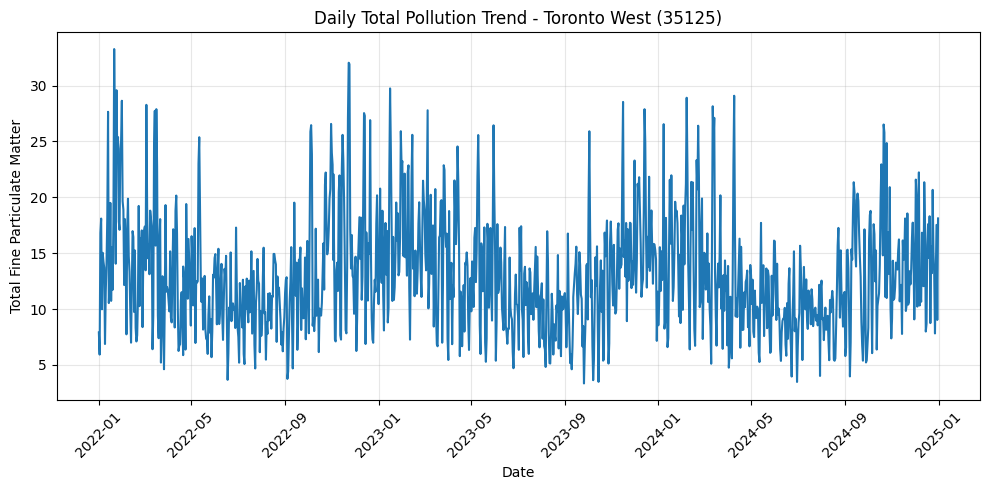

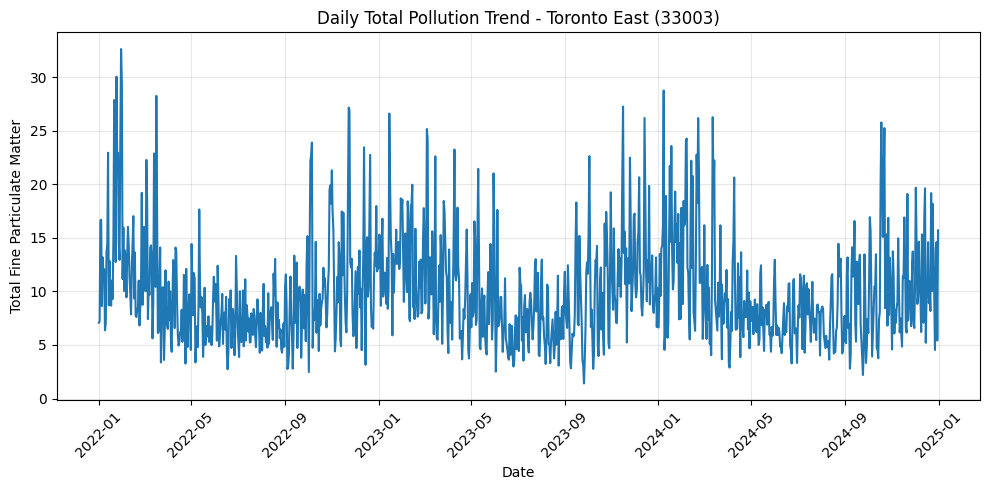

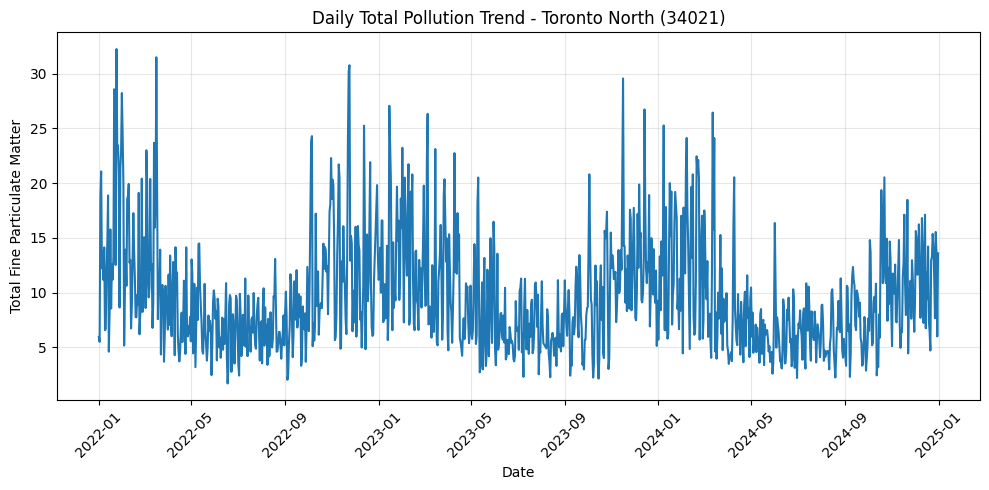

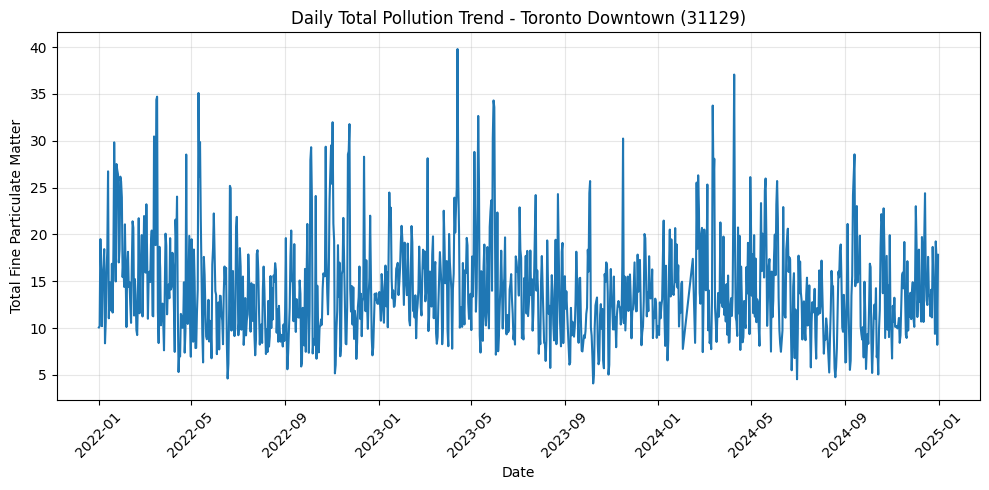

In [28]:

#  Create the list of hourly columns and take the MEAN of them
hourly_cols = [f'H{i:02d}' for i in range(1, 25)]
master_df['daily_total'] = master_df[hourly_cols].mean(axis=1)

# Date conversion and cleaning
master_df['Date'] = pd.to_datetime(master_df['Date'], errors='coerce')
master_df = master_df.dropna(subset=['Date'])

# Drop rows where daily_total is less than 0
# This ensures you aren't plotting negative pollution levels
master_df = master_df[master_df['daily_total'] >= 0]

# Plotting loop 
unique_stations = master_df['Station_Name'].unique()

# Loop through and create a normal line plot for each station
for station_name in unique_stations:
    # Filter data for the specific station name and ensure it's chronologically ordered
    subset = master_df[master_df['Station_Name'] == station_name].sort_values('Date')
    
    if not subset.empty:
        plt.figure(figsize=(10, 5))
        
        # Plotting the daily total for that specific station name
        plt.plot(subset['Date'], subset['daily_total'], linestyle='-')
        
        # Title now reflects the actual name instead of a numeric ID
        plt.title(f'Daily Total Pollution Trend - {station_name}')
        plt.xlabel('Date')
        plt.ylabel('Total Fine Particulate Matter')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

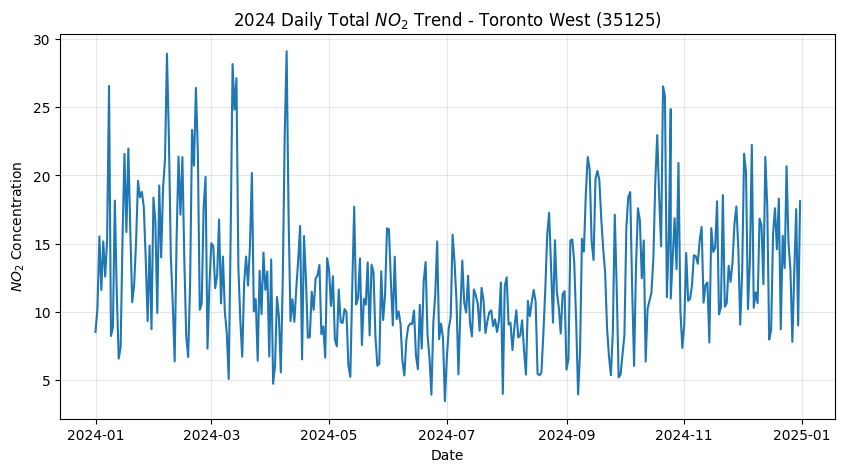

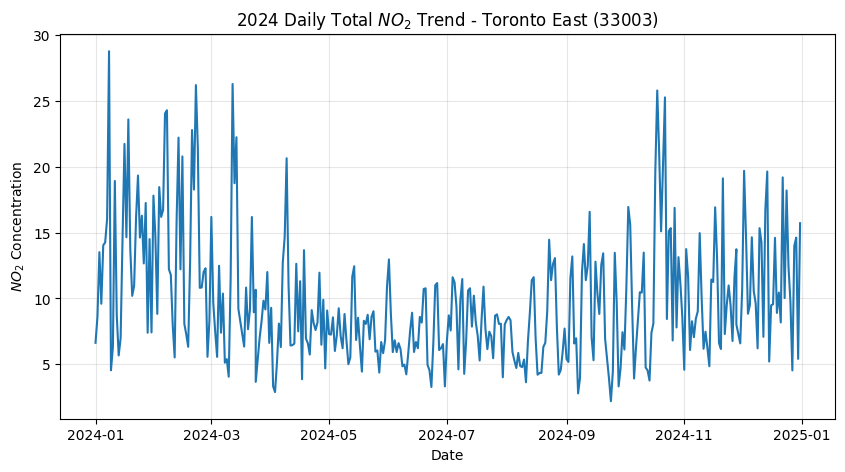

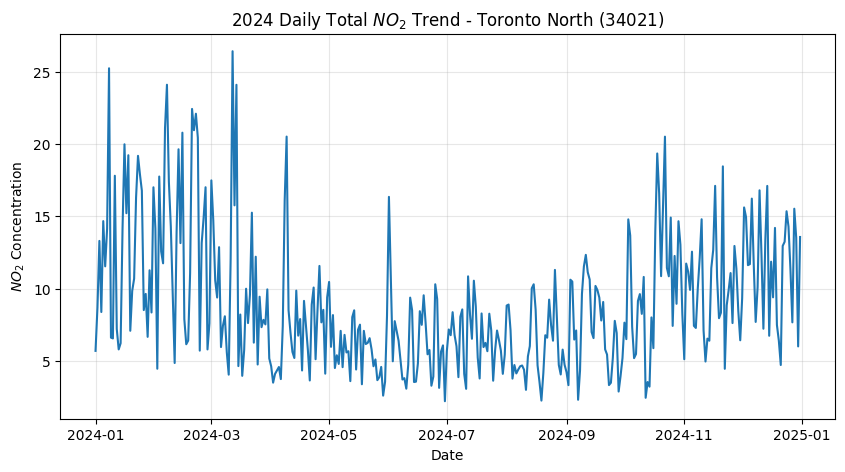

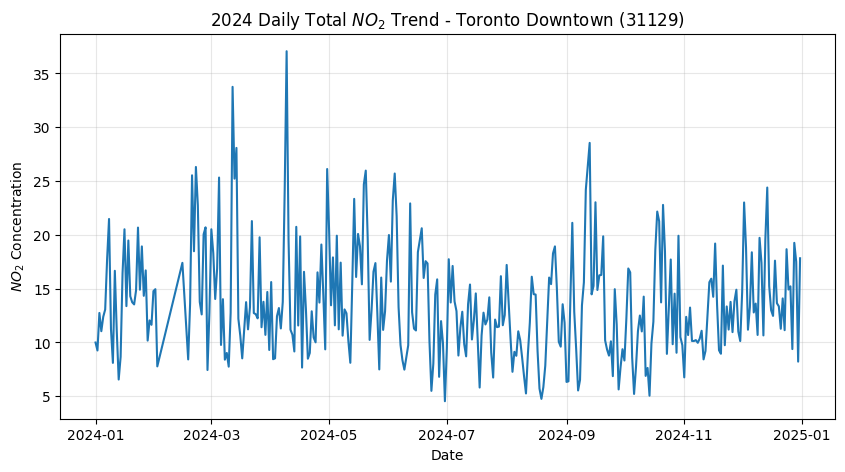

In [29]:
# Filter for a specific year
target_year = 2024
target_year__df = master_df[master_df['Date'].dt.year == target_year]

# Use Station_Name for the loop instead of ID
unique_station_names = target_year__df['Station_Name'].unique()

for name in unique_station_names:
    # Filter using the Station_Name column
    subset = target_year__df[target_year__df['Station_Name'] == name].sort_values('Date')
    
    if not subset.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(subset['Date'], subset['daily_total'], linestyle='-')
            
        # Title now uses the name, and the Y-axis label reflects N02
        plt.title(f'{target_year} Daily Total $NO_2$ Trend - {name}')
        plt.xlabel('Date')
        plt.ylabel('$NO_2$ Concentration')
        plt.grid(True, alpha=0.3)
        plt.show()

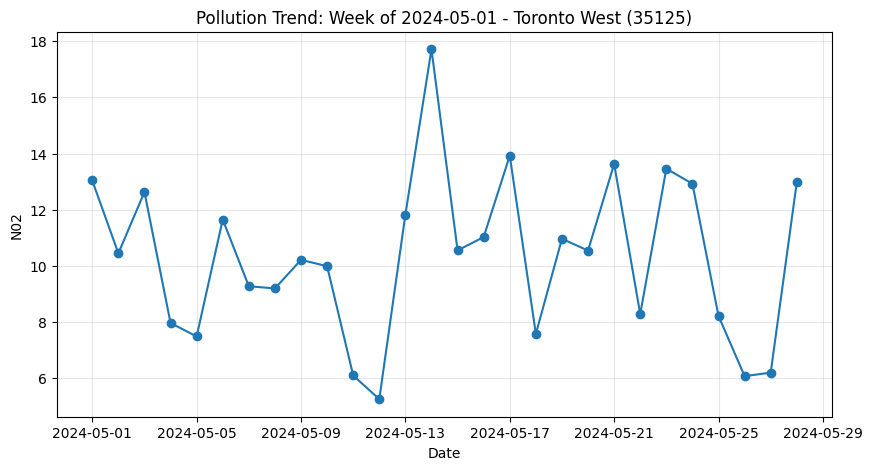

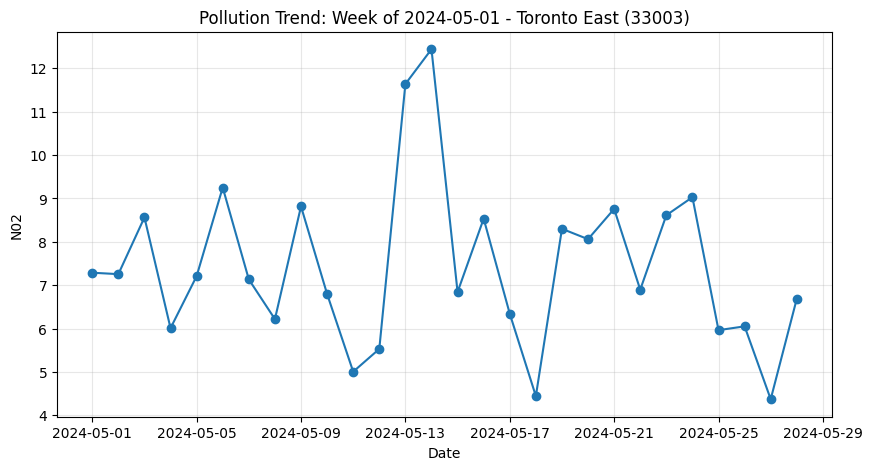

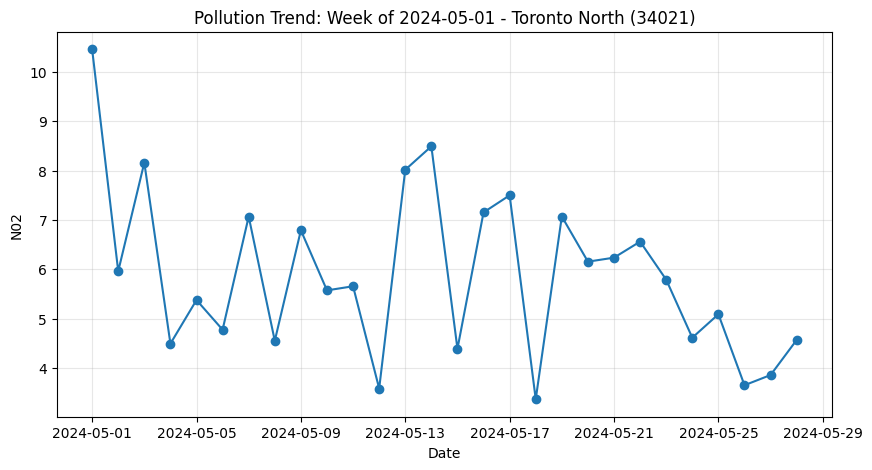

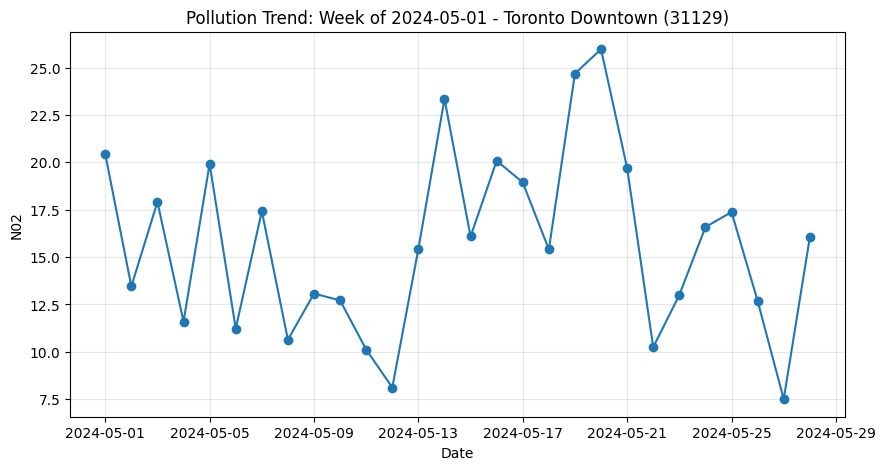

In [30]:
# Filter for a specific week
# Choose your start date 
start_date = pd.to_datetime('2024-05-01')
end_date = start_date + pd.Timedelta(days=28)

# Create the weekly dataframe
weekly_df = target_year__df[(target_year__df['Date'] >= start_date) & 
                            (target_year__df['Date'] < end_date)]

# Now use weekly_df for your loop - use Station_Name instead of ID
unique_station_names = weekly_df['Station_Name'].unique()

for name in unique_station_names:
    # Filter using the Name instead of the ID
    subset = weekly_df[weekly_df['Station_Name'] == name].sort_values('Date')
    
    if not subset.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(subset['Date'], subset['daily_total'], linestyle='-', marker='o')
        
        # Updated Title to use the Name
        plt.title(f'Pollution Trend: Week of {start_date.date()} - {name}')
        plt.xlabel('Date')
        plt.ylabel('N02')
        plt.grid(True, alpha=0.3)
        plt.show()

In [31]:
# This is to see if pollution is less on weekends
#  Add a Day of Week column
target_year__df['Day_of_Week'] = target_year__df['Date'].dt.day_name()

#  Filter for just Sundays and Wednesdays
comparison_df = target_year__df[target_year__df['Day_of_Week'].isin(['Sunday', 'Wednesday'])]

#  Group by Station and Day to find the average pollution levels
traffic_signal = comparison_df.groupby(['Station_Name', 'Day_of_Week'])['daily_total'].mean().unstack()

#  Calculate the percentage drop on Sundays
traffic_signal['% Change'] = ((traffic_signal['Sunday'] - traffic_signal['Wednesday']) / traffic_signal['Wednesday']) * 100

print("Comparison of $NO_2$ Levels: Mid-Week vs. Weekend")
print(traffic_signal.sort_values('% Change'))

Comparison of $NO_2$ Levels: Mid-Week vs. Weekend
Day_of_Week                  Sunday  Wednesday   % Change
Station_Name                                             
Toronto West (35125)        9.48558  13.146846 -27.849005
Toronto North (34021)       7.31403   9.278436 -21.171737
Toronto Downtown (31129)  11.815822  13.396307 -11.797916
Toronto East (33003)       8.390121   9.485222 -11.545334


/var/folders/rg/6_hb8rjj4tlct__31r7vx4640000gp/T/ipykernel_99206/3503768812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_year__df['Day_of_Week'] = target_year__df['Date'].dt.day_name()


In [32]:
target_year__df

,Station ID,Pollutant,Date,H01,H02,H03,H04,H05,H06,H07,...,H20,H21,H22,H23,H24,Station_Name,Latitude,Longitude,daily_total,Day_of_Week
730,35125,Nitrogen Dioxide,2024-01-01,11.8,11.0,8.0,<NA>,8.6,8.8,6.4,...,6.6,7.4,7.0,7.7,7.0,Toronto West (35125),43.709444,-79.5435,8.543478,Monday
731,35125,Nitrogen Dioxide,2024-01-02,7.8,6.5,6.8,5.8,7.8,7.2,10.4,...,11.2,12.6,11.8,11.3,9.9,Toronto West (35125),43.709444,-79.5435,10.291667,Tuesday
732,35125,Nitrogen Dioxide,2024-01-03,8.8,8.9,9.7,10.7,10.3,14.3,18.6,...,14.9,17.3,18.6,21.2,15.0,Toronto West (35125),43.709444,-79.5435,15.5375,Wednesday
733,35125,Nitrogen Dioxide,2024-01-04,9.7,4.9,3.4,3.6,3.8,6.5,8.1,...,17.9,21.2,18.0,13.7,11.0,Toronto West (35125),43.709444,-79.5435,11.608333,Thursday
734,35125,Nitrogen Dioxide,2024-01-05,10.9,8.9,9.2,7.5,9.9,11.5,15.2,...,18.4,19.2,19.6,14.9,16.4,Toronto West (35125),43.709444,-79.5435,15.166667,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,31129,Nitrogen Dioxide,2024-12-27,<NA>,7.5,6.1,6.1,6.6,8.1,18.2,...,6.8,7.2,6.8,7.5,8.9,Toronto Downtown (31129),43.645451,-79.3891,9.386957,Friday
4389,31129,Nitrogen Dioxide,2024-12-28,<NA>,7.2,7.2,7.9,9.0,13.4,10.9,...,15.2,18.0,18.1,22.8,28.4,Toronto Downtown (31129),43.645451,-79.3891,19.26087,Saturday
4390,31129,Nitrogen Dioxide,2024-12-29,<NA>,22.6,25.0,24.8,26.1,26.7,29.3,...,21.8,31.5,26.2,16.1,5.3,Toronto Downtown (31129),43.645451,-79.3891,17.495652,Sunday
4391,31129,Nitrogen Dioxide,2024-12-30,<NA>,3.5,3.4,2.9,2.6,2.9,4.8,...,9.1,10.4,12.0,12.1,12.5,Toronto Downtown (31129),43.645451,-79.3891,8.221739,Monday


# Traffic Data Integration

This section integrates traffic camera data with air quality measurements to explore potential correlations between traffic volume and pollution levels.

In [33]:
# Load traffic data from the filtered CSV
traffic_path = "../Traffic Dataset - Statistics Canada/filtered_roads_with_sums.csv"
traffic_df = pd.read_csv(traffic_path)

print(f"Traffic data loaded: {len(traffic_df)} cameras")
print("\nTraffic camera locations:")
print(traffic_df['camera_road'].unique())

Traffic data loaded: 4 cameras

Traffic camera locations:
['FRONT ST W / JOHN ST / PRIVATE ACCESS' 'STEELES AVE W / DUFFERIN ST'
 'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE'
 'LAWRENCE AVE E / KENNEDY RD']


In [34]:
# Create mapping between traffic cameras and air quality stations
location_mapping = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East (33003)',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North (34021)',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown (31129)',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West (35125)'
}

print("Location Mapping:")
for traffic_loc, aq_station in location_mapping.items():
    print(f"  Traffic: {traffic_loc}")
    print(f"  Air Quality: {aq_station}\n")

Location Mapping:
  Traffic: LAWRENCE AVE E / KENNEDY RD
  Air Quality: Toronto East (33003)

  Traffic: STEELES AVE W / DUFFERIN ST
  Air Quality: Toronto North (34021)

  Traffic: FRONT ST W / JOHN ST / PRIVATE ACCESS
  Air Quality: Toronto Downtown (31129)

  Traffic: ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE
  Air Quality: Toronto West (35125)



In [35]:
# Transform traffic data from wide to long format (similar to air quality data)
import re

# Identify daily traffic columns (format: xYYYY_MM_DD)
date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
traffic_date_cols = [c for c in traffic_df.columns if date_col_pattern.match(str(c))]

print(f"Found {len(traffic_date_cols)} traffic date columns")

# Transform to long format
traffic_long = []

for idx, row in traffic_df.iterrows():
    camera_road = row['camera_road']
    # Map to air quality station name
    aq_station = location_mapping.get(camera_road, camera_road)
    
    for col in traffic_date_cols:
        traffic_value = row[col]
        if pd.notna(traffic_value):  # Only include non-NA values
            # Parse date from column name (remove 'x' prefix and convert underscores)
            date_str = col[1:]  # Remove 'x'
            date = pd.to_datetime(date_str, format='%Y_%m_%d')
            traffic_long.append({
                'Date': date,
                'camera_road': camera_road,
                'Station_Name': aq_station,
                'traffic_count': traffic_value
            })

# Create DataFrame
traffic_long_df = pd.DataFrame(traffic_long)
print(f"\nTraffic data points: {len(traffic_long_df)}")
print(f"Date range: {traffic_long_df['Date'].min()} to {traffic_long_df['Date'].max()}")
traffic_long_df.head()

Found 1368 traffic date columns

Traffic data points: 4300
Date range: 2022-02-03 00:00:00 to 2025-10-31 00:00:00


,Date,camera_road,Station_Name,traffic_count
0,2022-02-03,FRONT ST W / JOHN ST / PRIVATE ACCESS,Toronto Downtown (31129),320.0
1,2022-02-04,FRONT ST W / JOHN ST / PRIVATE ACCESS,Toronto Downtown (31129),269.0
2,2022-02-05,FRONT ST W / JOHN ST / PRIVATE ACCESS,Toronto Downtown (31129),161.0
3,2022-02-06,FRONT ST W / JOHN ST / PRIVATE ACCESS,Toronto Downtown (31129),98.0
4,2022-02-07,FRONT ST W / JOHN ST / PRIVATE ACCESS,Toronto Downtown (31129),151.0


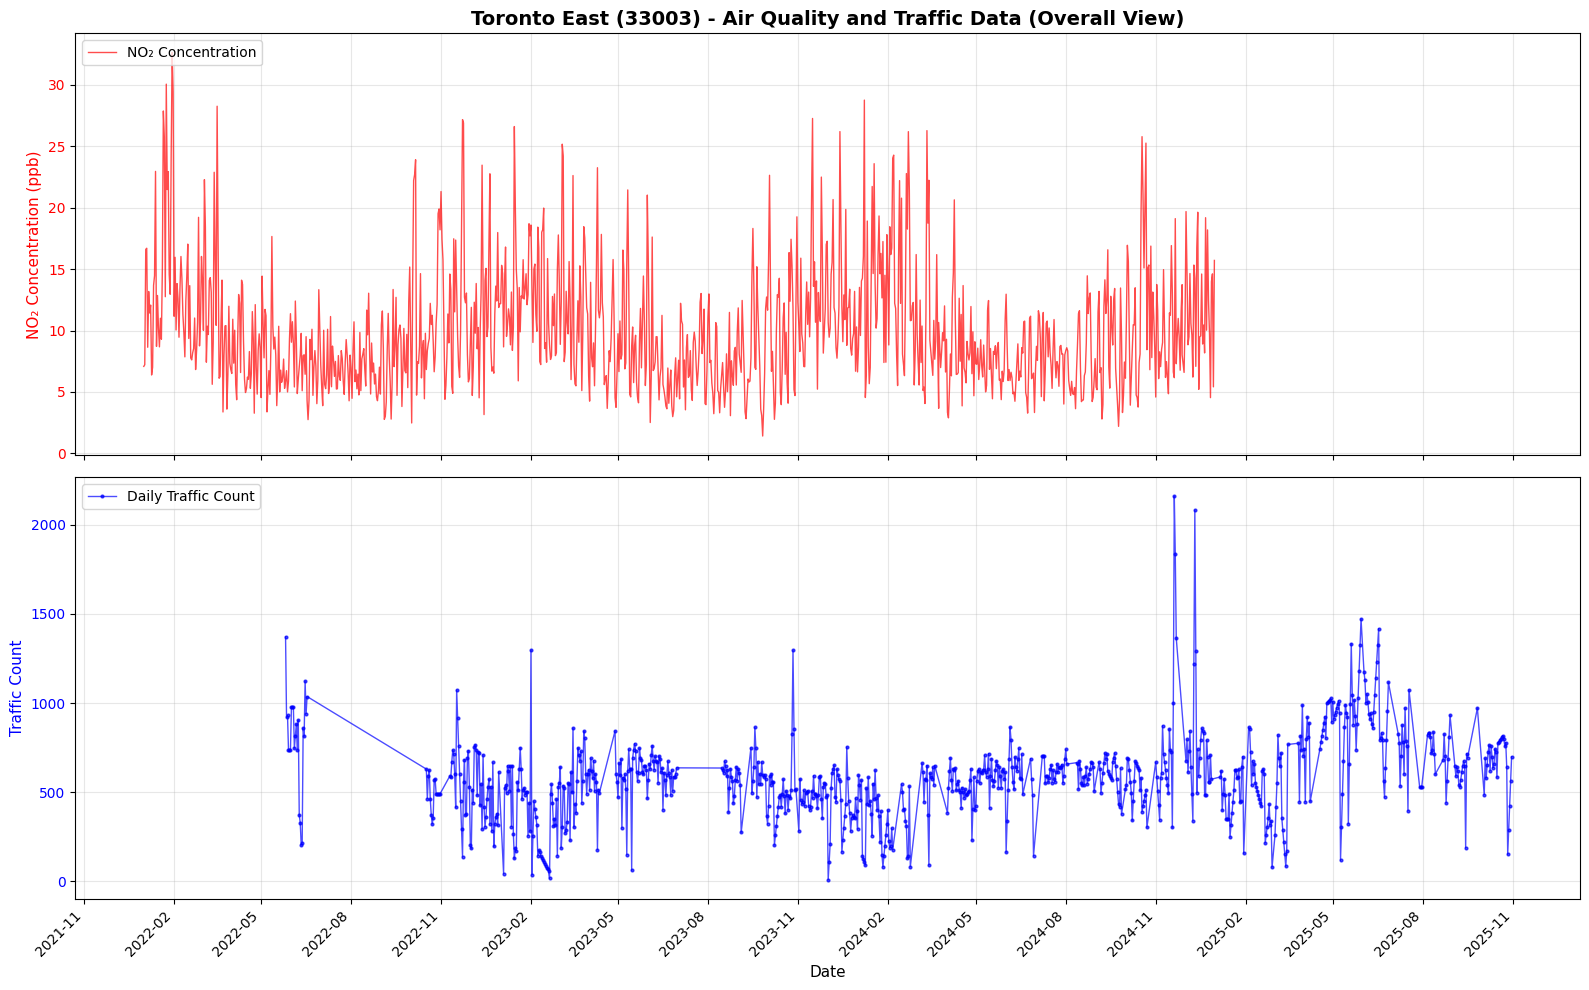

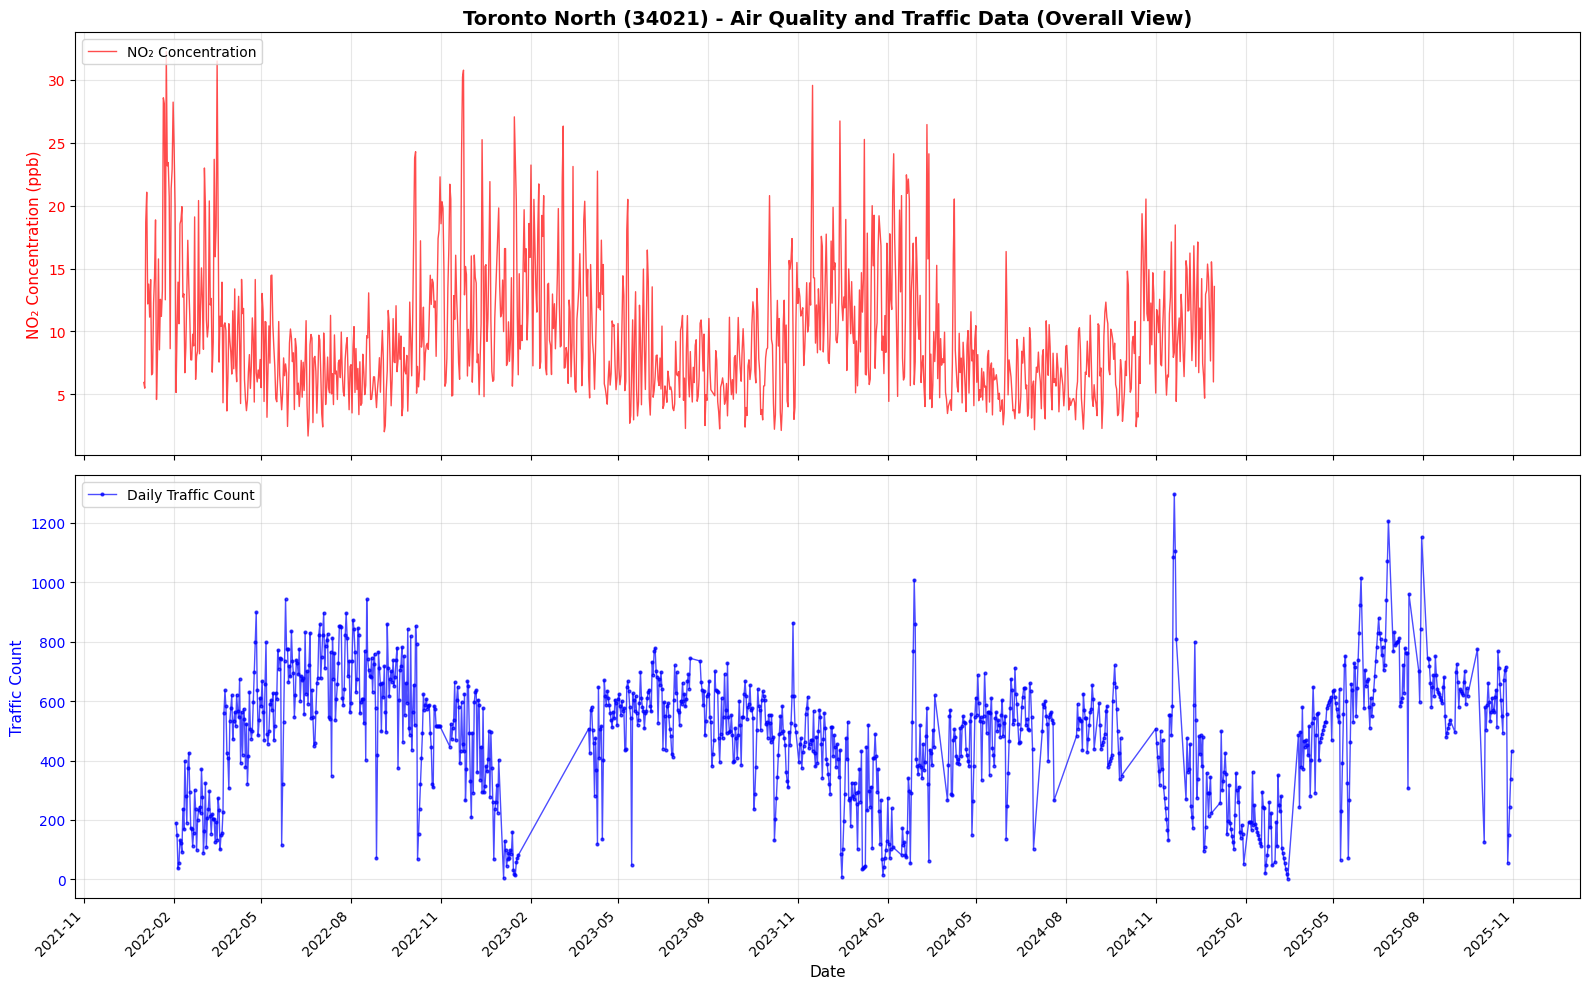

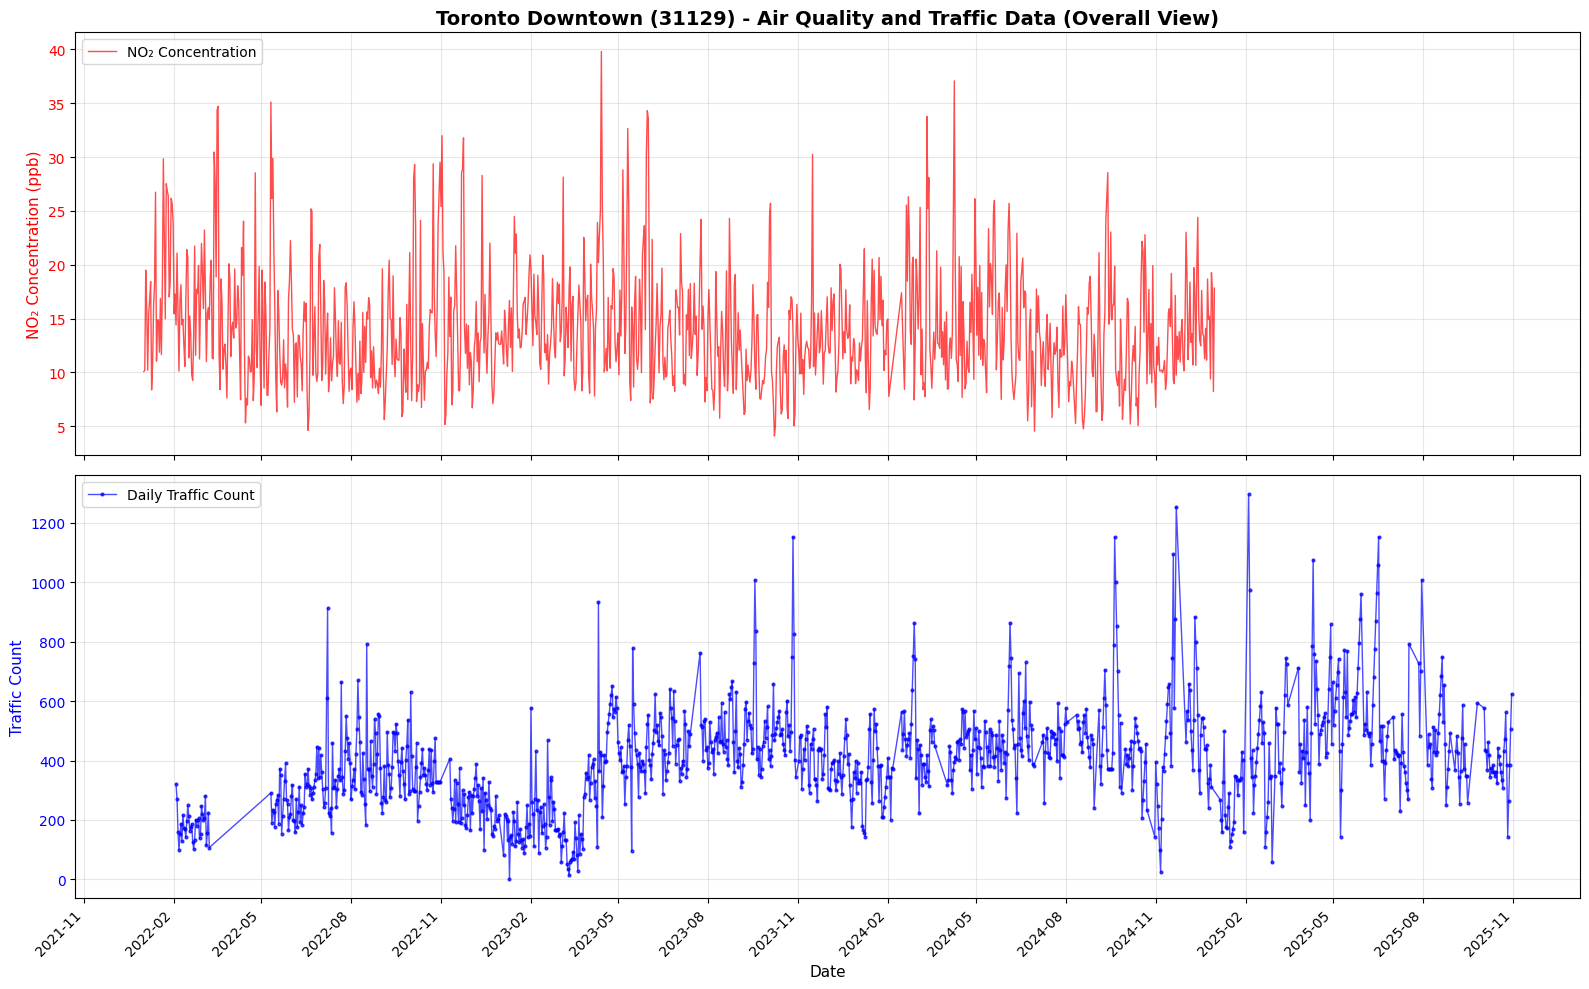

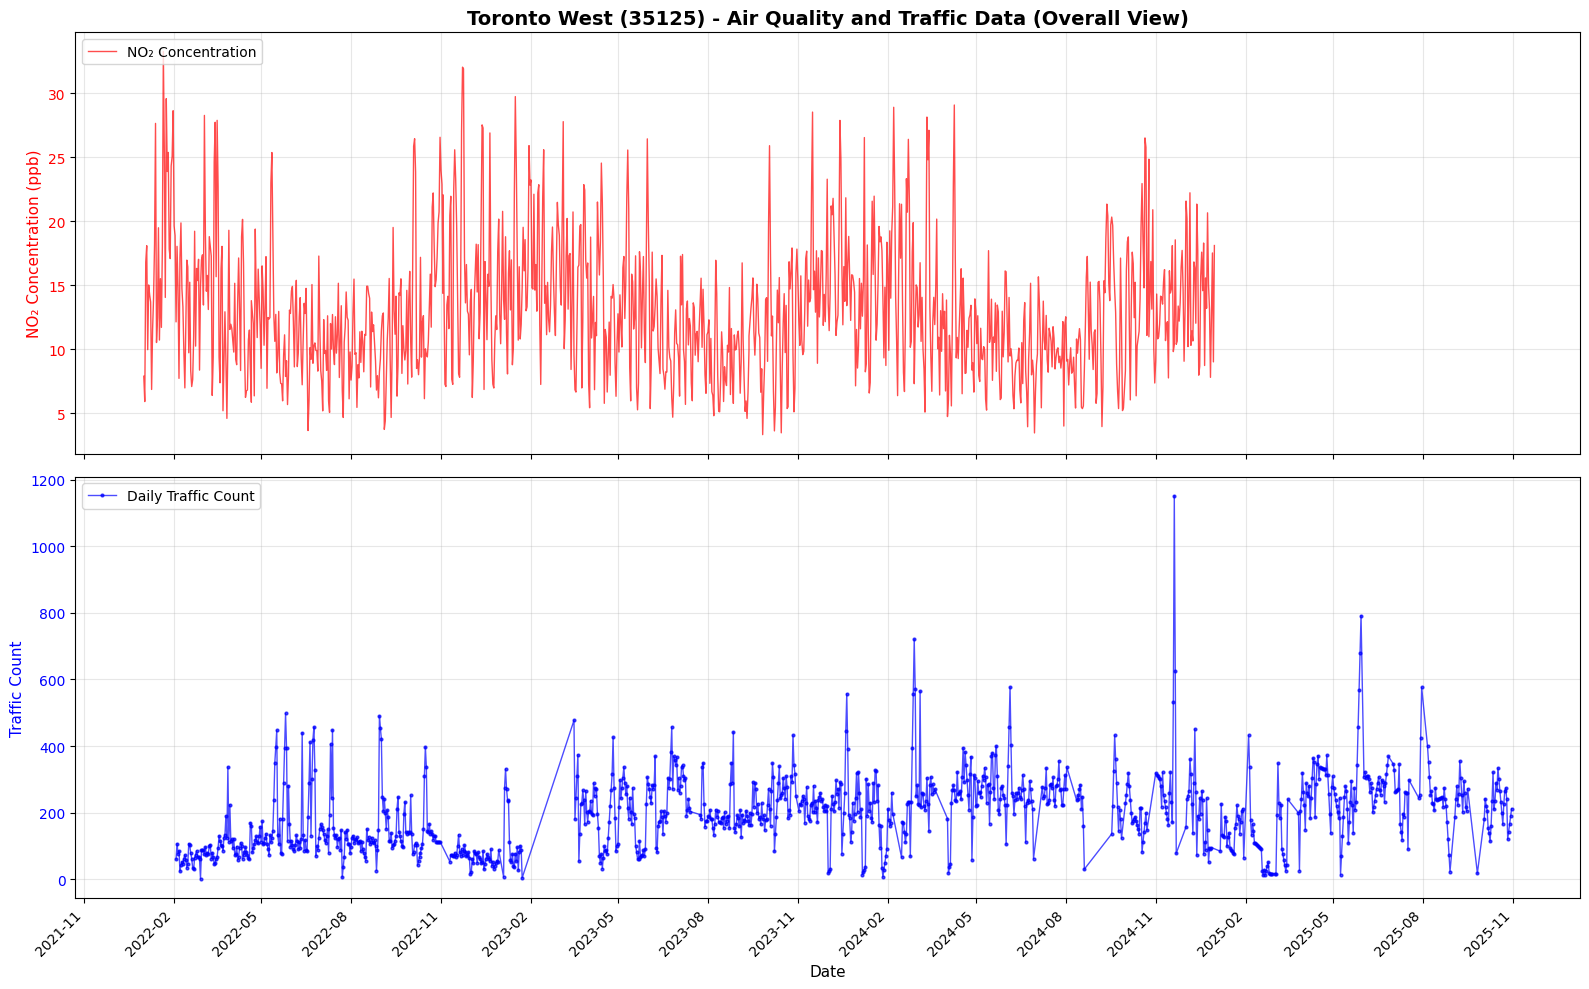

In [36]:
# COMBINED PLOT 1: Overall View - All Data
# This creates a plot for each location showing both traffic and air quality

import matplotlib.dates as mdates

for station_name in location_mapping.values():
    # Get air quality data for this station
    aq_data = master_df[master_df['Station_Name'] == station_name].sort_values('Date')
    
    # Get traffic data for this station
    traffic_data = traffic_long_df[traffic_long_df['Station_Name'] == station_name].sort_values('Date')
    
    if not aq_data.empty and not traffic_data.empty:
        # Create figure with two subplots stacked vertically
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
        
        # Plot 1: Air Quality (NO2)
        ax1.plot(aq_data['Date'], aq_data['daily_total'], 
                color='red', linewidth=1, alpha=0.7, label='NO₂ Concentration')
        ax1.set_ylabel('NO₂ Concentration (ppb)', fontsize=11, color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'{station_name} - Air Quality and Traffic Data (Overall View)', 
                     fontsize=14, fontweight='bold')
        ax1.legend(loc='upper left')
        
        # Plot 2: Traffic Count
        ax2.plot(traffic_data['Date'], traffic_data['traffic_count'], 
                color='blue', linewidth=1, alpha=0.7, marker='o', markersize=2, 
                label='Daily Traffic Count')
        ax2.set_ylabel('Traffic Count', fontsize=11, color='blue')
        ax2.set_xlabel('Date', fontsize=11)
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')
        
        # Format x-axis
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Insufficient data for {station_name}")

Viewing data from 2024-01-01 to 2024-01-07
Duration: 7 days

Toronto East (33003): 7 AQ readings, 7 traffic readings


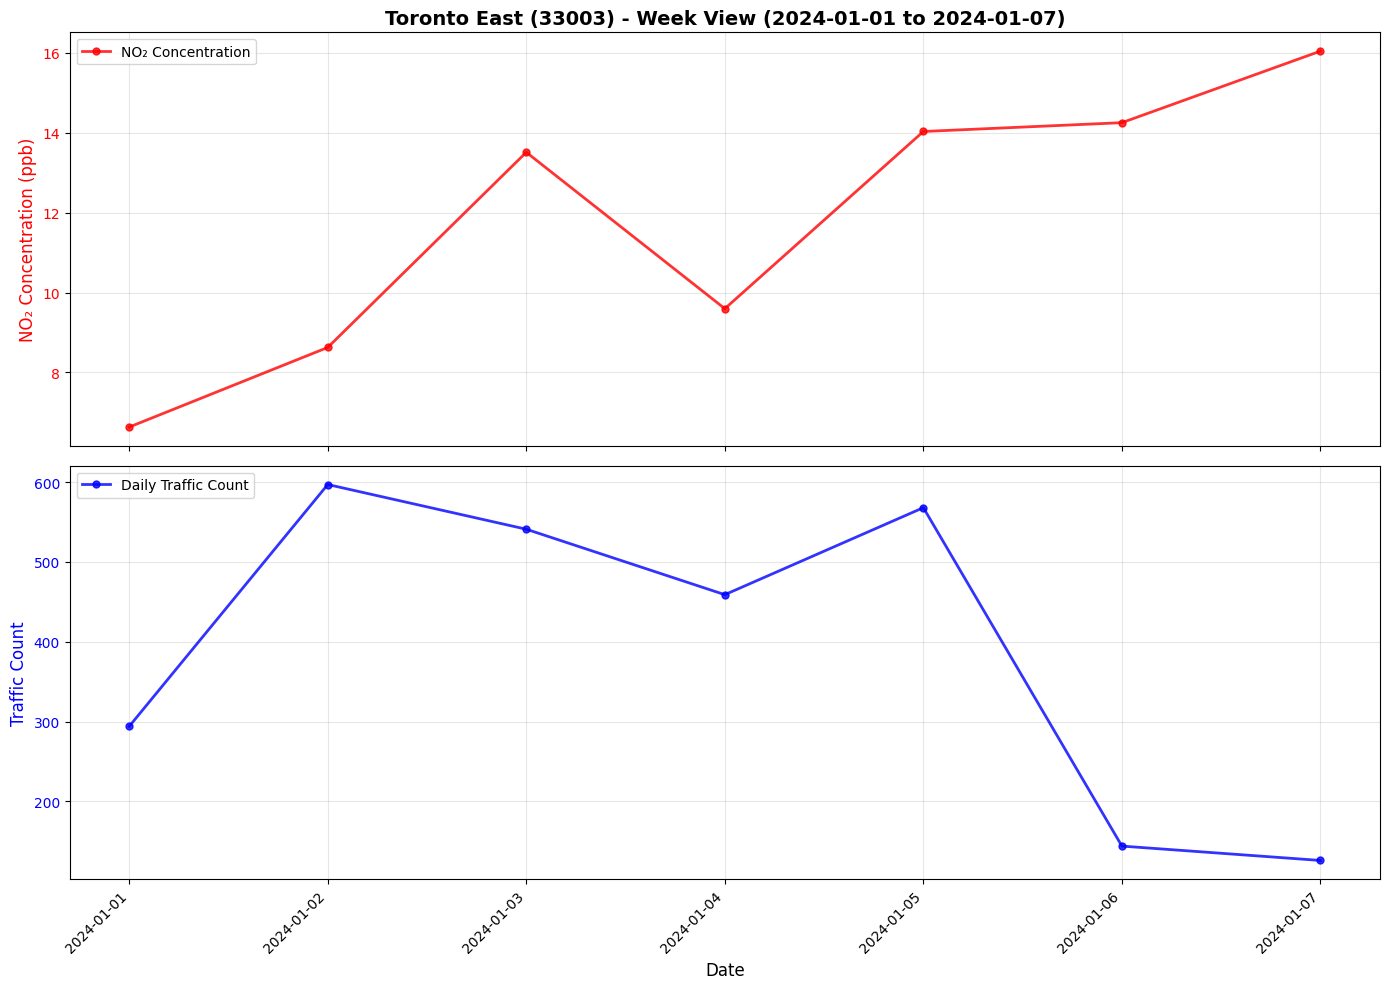

Toronto North (34021): 7 AQ readings, 7 traffic readings


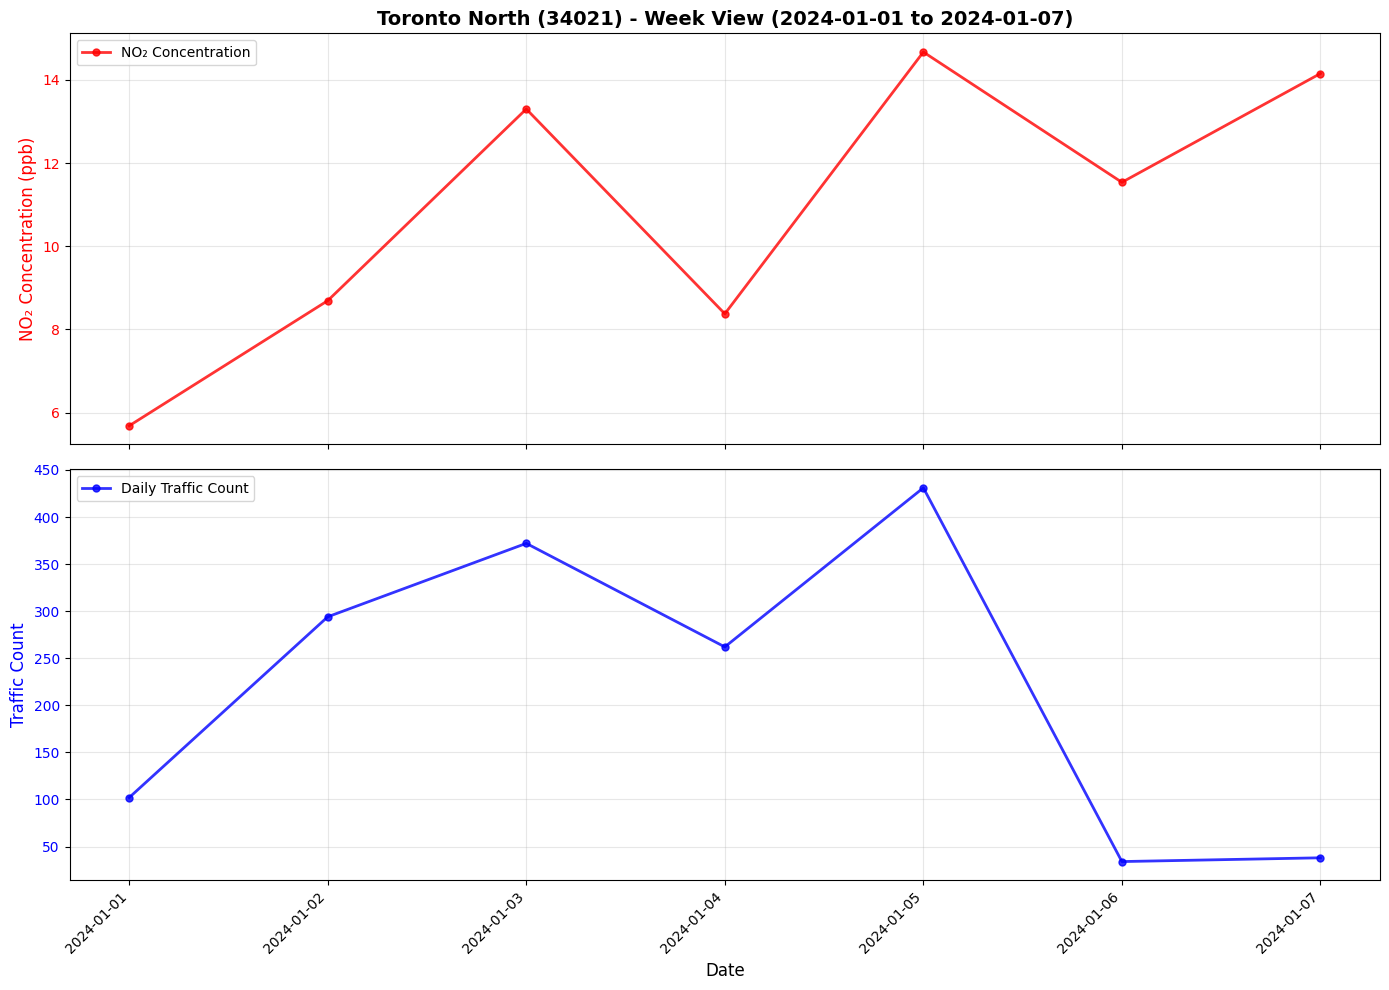

Toronto Downtown (31129): 7 AQ readings, 7 traffic readings


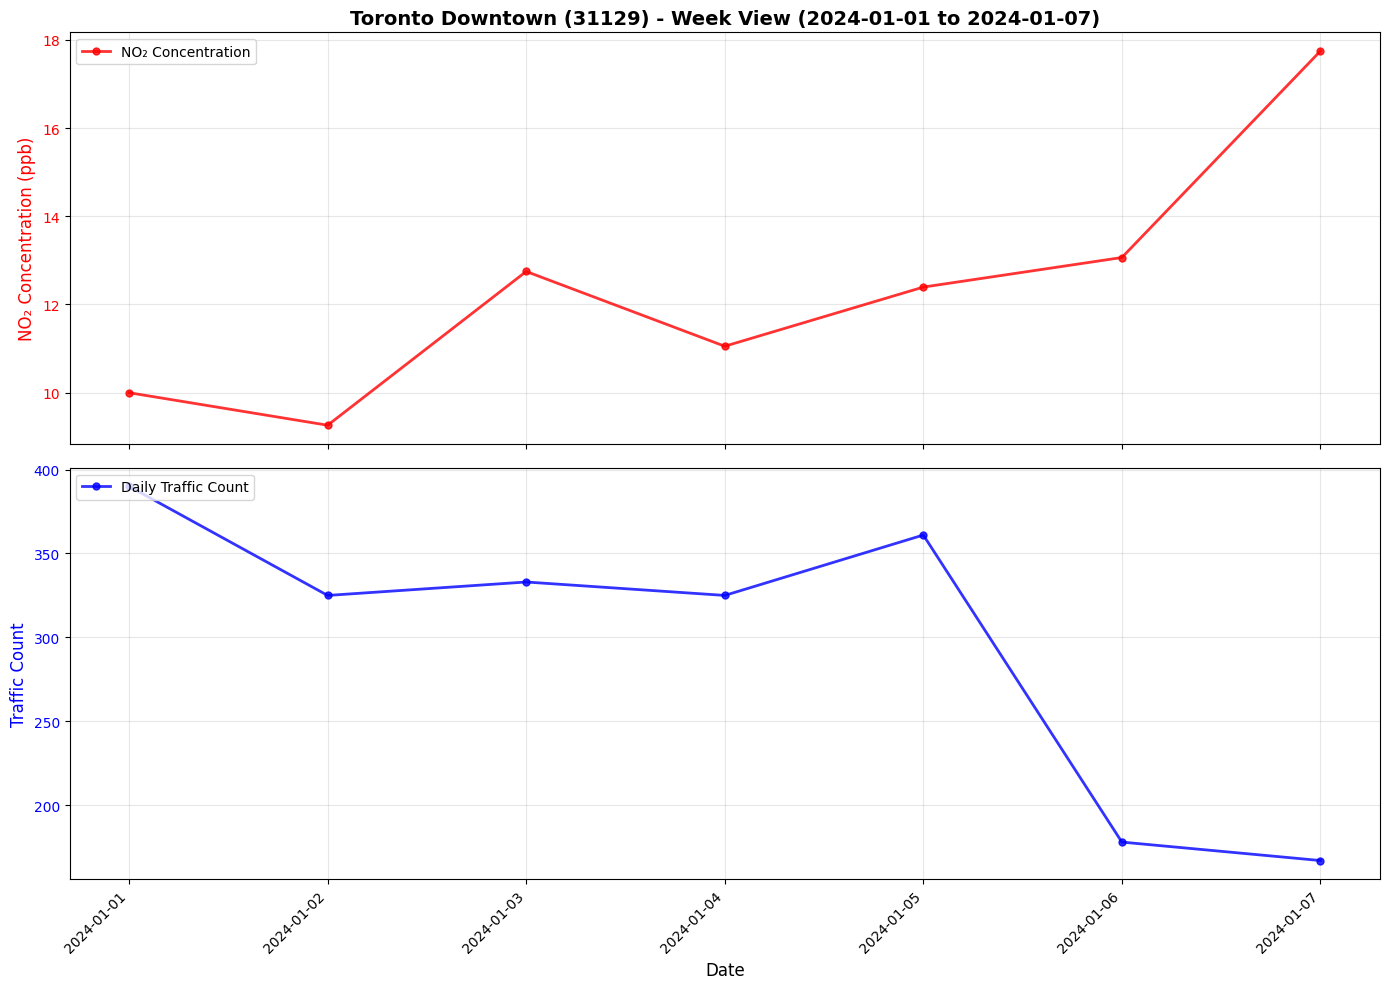

Toronto West (35125): 7 AQ readings, 7 traffic readings


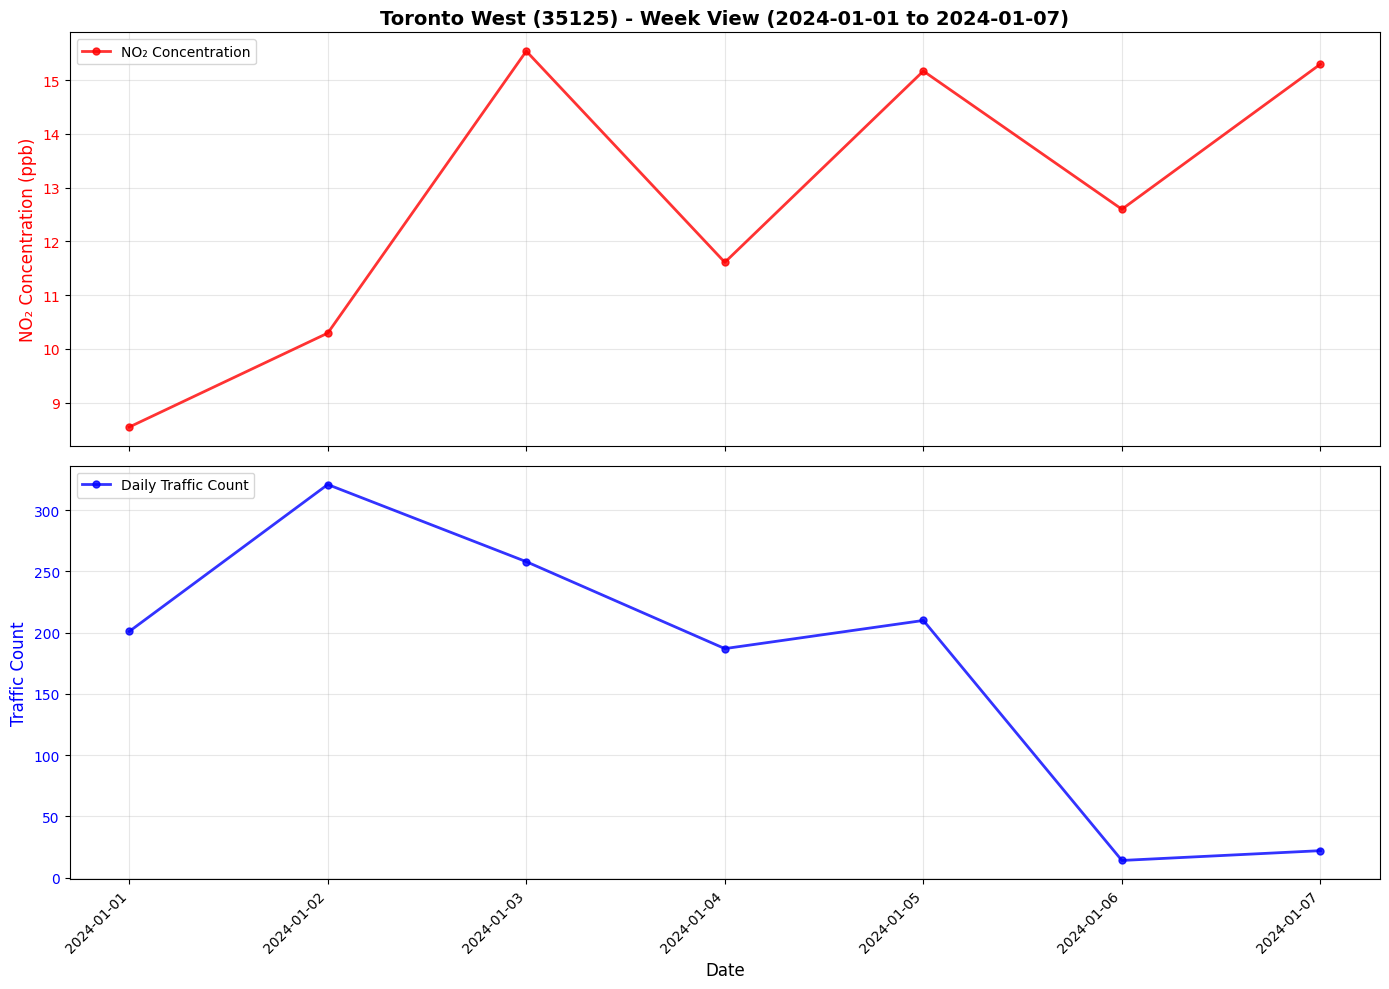

In [37]:
# COMBINED PLOT 2: Filtered Date Range View
# ========================================
# MODIFY THESE DATES TO VIEW DIFFERENT TIME PERIODS
# ========================================
start_date = '2024-01-01'  # <-- CHANGE THIS: Start date (YYYY-MM-DD)
end_date = '2024-01-07'    # <-- CHANGE THIS: End date (YYYY-MM-DD)
# ========================================

# Convert to datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

print(f"Viewing data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Duration: {(end_date - start_date).days + 1} days\n")

for station_name in location_mapping.values():
    # Filter air quality data by date range
    aq_data = master_df[
        (master_df['Station_Name'] == station_name) & 
        (master_df['Date'] >= start_date) & 
        (master_df['Date'] <= end_date)
    ].sort_values('Date')
    
    # Filter traffic data by date range
    traffic_data = traffic_long_df[
        (traffic_long_df['Station_Name'] == station_name) & 
        (traffic_long_df['Date'] >= start_date) & 
        (traffic_long_df['Date'] <= end_date)
    ].sort_values('Date')
    
    if not aq_data.empty and not traffic_data.empty:
        print(f"{station_name}: {len(aq_data)} AQ readings, {len(traffic_data)} traffic readings")
        
        # Create figure with two subplots stacked vertically
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
        
        # Plot 1: Air Quality (NO2)
        ax1.plot(aq_data['Date'], aq_data['daily_total'], 
                color='red', linewidth=2, alpha=0.8, marker='o', markersize=5,
                label='NO₂ Concentration')
        ax1.set_ylabel('NO₂ Concentration (ppb)', fontsize=12, color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'{station_name} - Week View ({start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")})', 
                     fontsize=14, fontweight='bold')
        ax1.legend(loc='upper left')
        
        # Plot 2: Traffic Count
        ax2.plot(traffic_data['Date'], traffic_data['traffic_count'], 
                color='blue', linewidth=2, alpha=0.8, marker='o', markersize=5,
                label='Daily Traffic Count')
        ax2.set_ylabel('Traffic Count', fontsize=12, color='blue')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper left')
        
        # Format x-axis to show each day
        ax2.xaxis.set_major_locator(mdates.DayLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"{station_name}: No data available in this date range")

Dual-axis view: 2024-05-01 to 2024-05-28



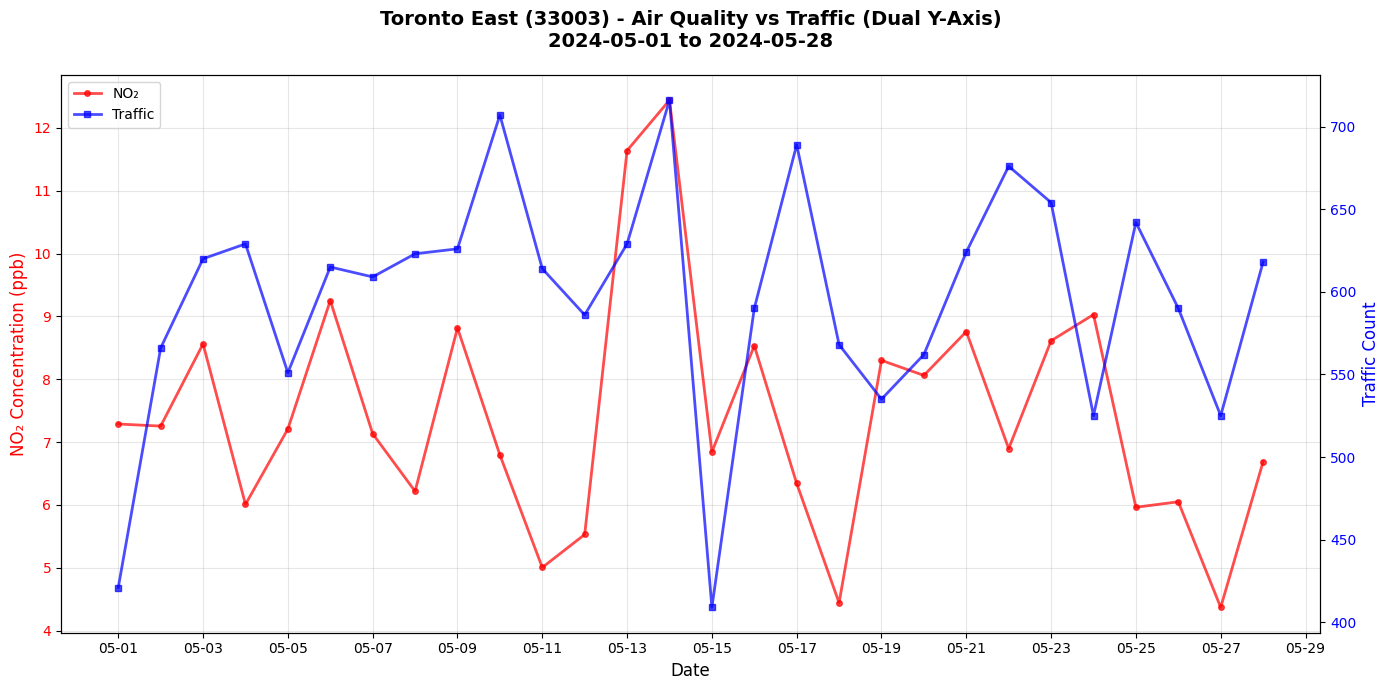

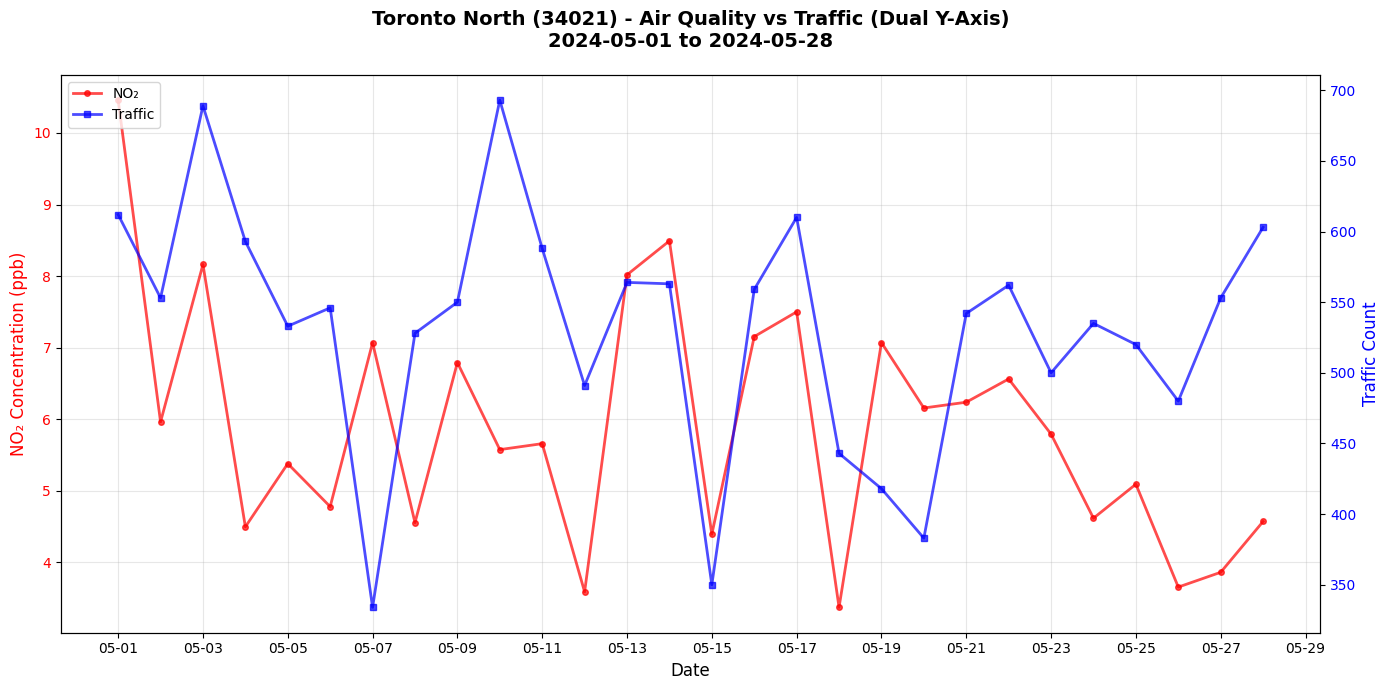

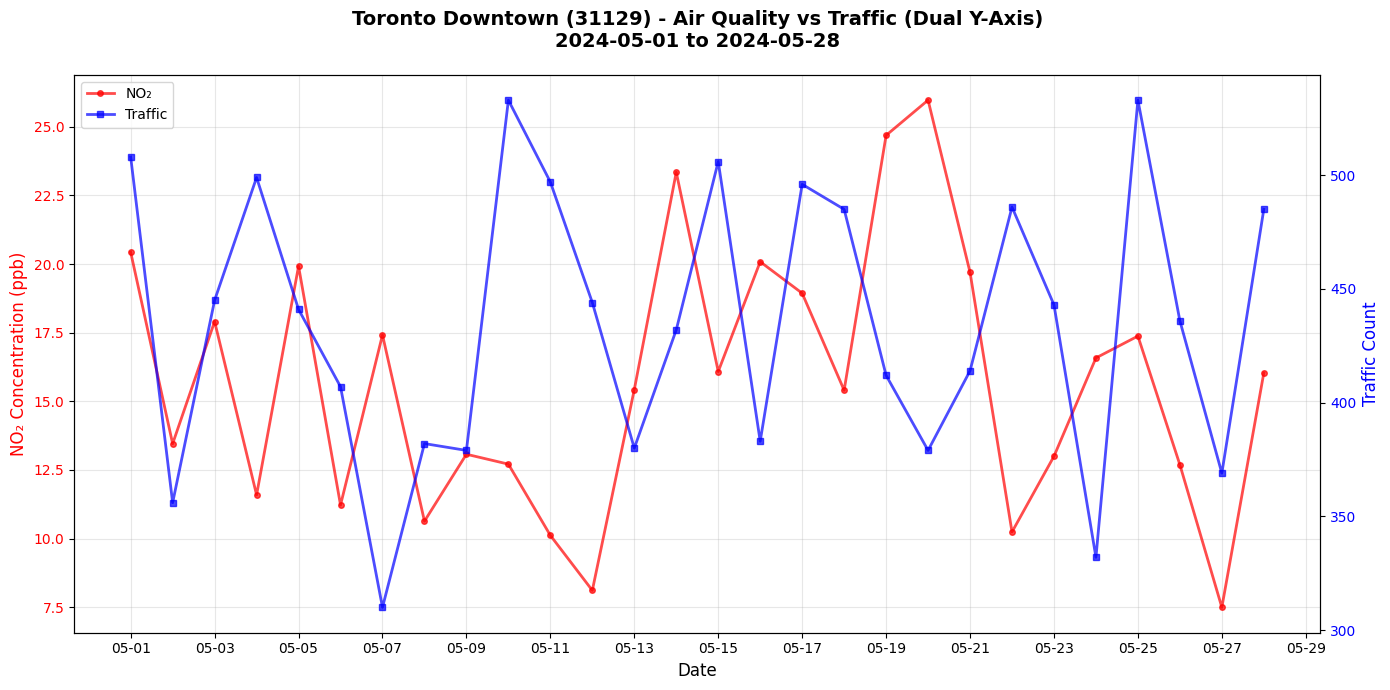

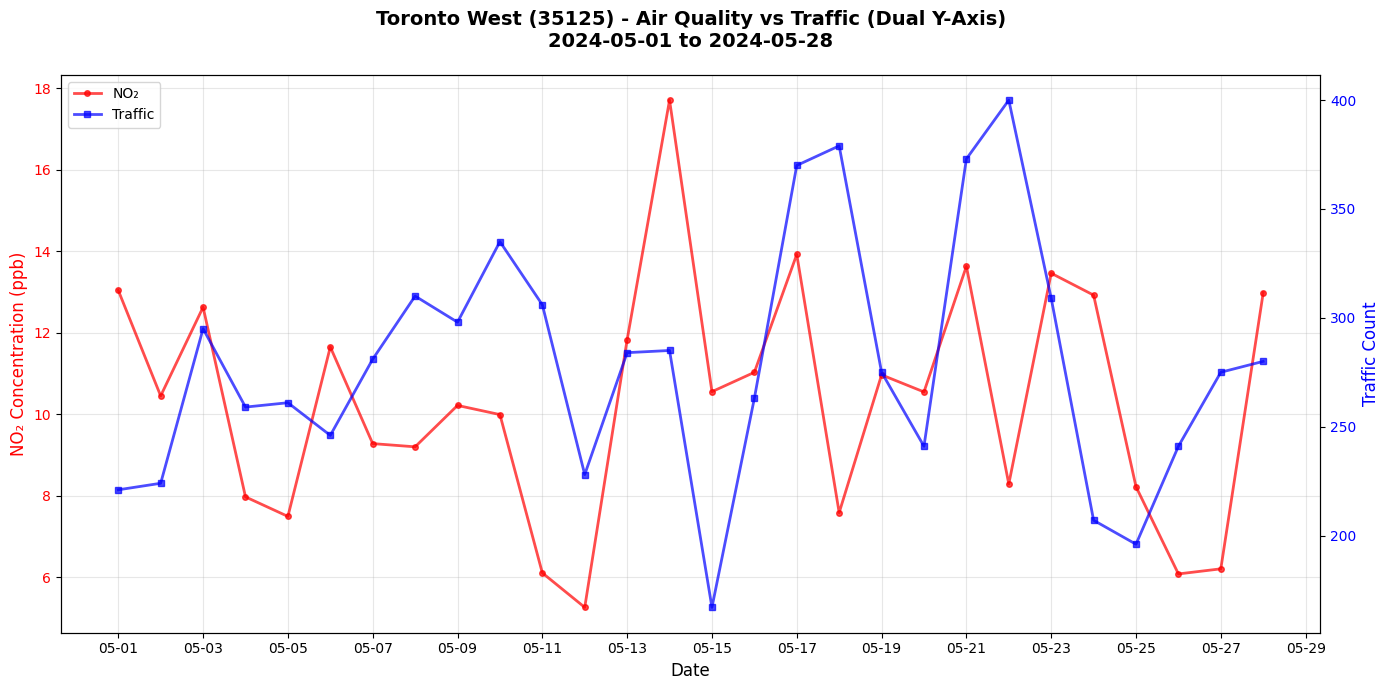

In [38]:
# COMBINED PLOT 3: Dual Y-Axis View (Both on same plot)
# This plots traffic and air quality on the same chart with separate y-axes
# ========================================
# MODIFY THESE DATES TO VIEW DIFFERENT TIME PERIODS
# ========================================
start_date_dual = '2024-05-01'  # <-- CHANGE THIS: Start date (YYYY-MM-DD)
end_date_dual = '2024-05-28'    # <-- CHANGE THIS: End date (YYYY-MM-DD)
# ========================================

start_date_dual = pd.to_datetime(start_date_dual)
end_date_dual = pd.to_datetime(end_date_dual)

print(f"Dual-axis view: {start_date_dual.strftime('%Y-%m-%d')} to {end_date_dual.strftime('%Y-%m-%d')}\n")

for station_name in location_mapping.values():
    # Filter data by date range
    aq_data = master_df[
        (master_df['Station_Name'] == station_name) & 
        (master_df['Date'] >= start_date_dual) & 
        (master_df['Date'] <= end_date_dual)
    ].sort_values('Date')
    
    traffic_data = traffic_long_df[
        (traffic_long_df['Station_Name'] == station_name) & 
        (traffic_long_df['Date'] >= start_date_dual) & 
        (traffic_long_df['Date'] <= end_date_dual)
    ].sort_values('Date')
    
    if not aq_data.empty and not traffic_data.empty:
        # Create figure with dual y-axis
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot Air Quality on left y-axis
        color = 'red'
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('NO₂ Concentration (ppb)', fontsize=12, color=color)
        ax1.plot(aq_data['Date'], aq_data['daily_total'], 
                color=color, linewidth=2, alpha=0.7, marker='o', markersize=4,
                label='NO₂')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        
        # Create second y-axis for Traffic
        ax2 = ax1.twinx()
        color = 'blue'
        ax2.set_ylabel('Traffic Count', fontsize=12, color=color)
        ax2.plot(traffic_data['Date'], traffic_data['traffic_count'], 
                color=color, linewidth=2, alpha=0.7, marker='s', markersize=4,
                label='Traffic')
        ax2.tick_params(axis='y', labelcolor=color)
        
        # Title
        plt.title(f'{station_name} - Air Quality vs Traffic (Dual Y-Axis)\n{start_date_dual.strftime("%Y-%m-%d")} to {end_date_dual.strftime("%Y-%m-%d")}', 
                 fontsize=14, fontweight='bold', pad=20)
        
        # Format x-axis
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.xticks(rotation=45, ha='right')
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"{station_name}: No data available in this date range")

In [39]:
# HELPER: View available date ranges for each location
print("=" * 80)
print("AVAILABLE DATE RANGES BY LOCATION")
print("=" * 80)

for station_name in location_mapping.values():
    print(f"\n{station_name}")
    print("-" * 80)
    
    # Air quality date range
    aq_data = master_df[master_df['Station_Name'] == station_name]
    if not aq_data.empty:
        aq_min = aq_data['Date'].min()
        aq_max = aq_data['Date'].max()
        aq_count = len(aq_data)
        print(f"  AIR QUALITY:")
        print(f"    Start: {aq_min.strftime('%Y-%m-%d')}")
        print(f"    End:   {aq_max.strftime('%Y-%m-%d')}")
        print(f"    Data points: {aq_count}")
    else:
        print(f"  AIR QUALITY: No data")
    
    # Traffic date range
    traffic_data = traffic_long_df[traffic_long_df['Station_Name'] == station_name]
    if not traffic_data.empty:
        traffic_min = traffic_data['Date'].min()
        traffic_max = traffic_data['Date'].max()
        traffic_count = len(traffic_data)
        print(f"  TRAFFIC:")
        print(f"    Start: {traffic_min.strftime('%Y-%m-%d')}")
        print(f"    End:   {traffic_max.strftime('%Y-%m-%d')}")
        print(f"    Data points: {traffic_count}")
        
        # Overlapping date range
        if not aq_data.empty:
            overlap_start = max(aq_min, traffic_min)
            overlap_end = min(aq_max, traffic_max)
            print(f"  OVERLAP PERIOD:")
            print(f"    Start: {overlap_start.strftime('%Y-%m-%d')}")
            print(f"    End:   {overlap_end.strftime('%Y-%m-%d')}")
            print(f"    Duration: {(overlap_end - overlap_start).days + 1} days")
    else:
        print(f"  TRAFFIC: No data")

AVAILABLE DATE RANGES BY LOCATION

Toronto East (33003)
--------------------------------------------------------------------------------
  AIR QUALITY:
    Start: 2022-01-01
    End:   2024-12-31
    Data points: 1094
  TRAFFIC:
    Start: 2022-05-26
    End:   2025-10-31
    Data points: 886
  OVERLAP PERIOD:
    Start: 2022-05-26
    End:   2024-12-31
    Duration: 951 days

Toronto North (34021)
--------------------------------------------------------------------------------
  AIR QUALITY:
    Start: 2022-01-01
    End:   2024-12-31
    Data points: 1092
  TRAFFIC:
    Start: 2022-02-03
    End:   2025-10-31
    Data points: 1112
  OVERLAP PERIOD:
    Start: 2022-02-03
    End:   2024-12-31
    Duration: 1063 days

Toronto Downtown (31129)
--------------------------------------------------------------------------------
  AIR QUALITY:
    Start: 2022-01-01
    End:   2024-12-31
    Data points: 1081
  TRAFFIC:
    Start: 2022-02-03
    End:   2025-10-31
    Data points: 1158
  OVERLA

CORRELATION ANALYSIS: Traffic Count vs NO₂ Concentration

Toronto East (33003)
  Matched data points: 662
  Correlation coefficient: -0.1826


UFuncTypeError: Cannot cast ufunc 'lstsq_n' input 1 from dtype('O') to dtype('float64') with casting rule 'same_kind'

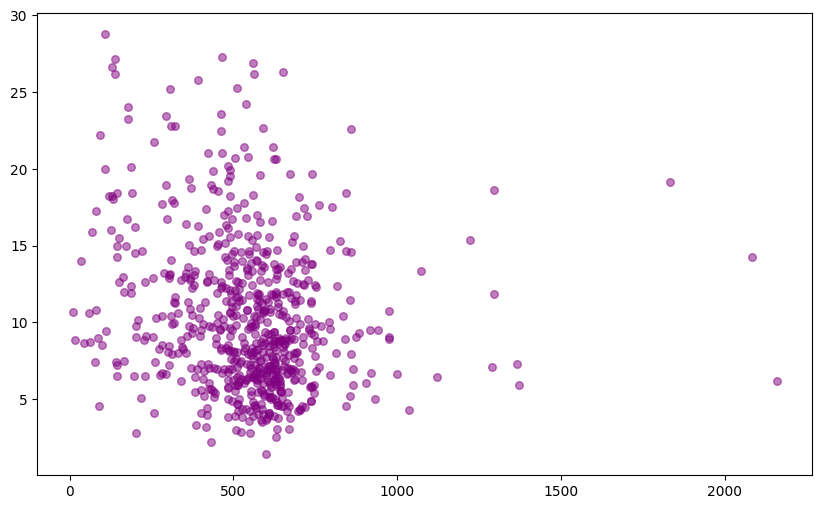

In [40]:
# CORRELATION ANALYSIS: Traffic vs Air Quality
# Merge traffic and air quality data on matching dates

print("CORRELATION ANALYSIS: Traffic Count vs NO₂ Concentration")
print("=" * 80)

for station_name in location_mapping.values():
    # Get data for this station
    aq_subset = master_df[master_df['Station_Name'] == station_name][['Date', 'daily_total']].copy()
    traffic_subset = traffic_long_df[traffic_long_df['Station_Name'] == station_name][['Date', 'traffic_count']].copy()
    
    if not aq_subset.empty and not traffic_subset.empty:
        # Merge on Date
        merged = pd.merge(aq_subset, traffic_subset, on='Date', how='inner')
        
        if len(merged) > 10:  # Only calculate if we have enough data points
            # Calculate correlation
            correlation = merged['daily_total'].corr(merged['traffic_count'])
            
            print(f"\n{station_name}")
            print(f"  Matched data points: {len(merged)}")
            print(f"  Correlation coefficient: {correlation:.4f}")
            
            # Create scatter plot
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(merged['traffic_count'], merged['daily_total'], 
                      alpha=0.5, s=30, color='purple')
            
            # Add trend line
            z = np.polyfit(merged['traffic_count'], merged['daily_total'], 1)
            p = np.poly1d(z)
            ax.plot(merged['traffic_count'], p(merged['traffic_count']), 
                   "r--", linewidth=2, alpha=0.8, label=f'Trend line (r={correlation:.3f})')
            
            ax.set_xlabel('Traffic Count', fontsize=12)
            ax.set_ylabel('NO₂ Concentration (ppb)', fontsize=12)
            ax.set_title(f'{station_name}\nTraffic vs Air Quality Correlation', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()
            plt.tight_layout()
            plt.show()
        else:
            print(f"\n{station_name}: Insufficient matched data points ({len(merged)})")
    else:
        print(f"\n{station_name}: Missing data for one or both datasets")

## Summary of Traffic Integration

The cells above integrate traffic camera data with air quality measurements. Here's what each visualization shows:

### Cell Structure:
1. **Load Traffic Data**: Reads the filtered traffic data CSV
2. **Location Mapping**: Maps traffic camera locations to air quality station names
3. **Transform Traffic Data**: Converts traffic data to long format (similar to AQ data)
4. **Overall View**: Stacked plots showing all traffic and AQ data for each location
5. **Filtered View**: Customizable date range plots (default: 1 week)
6. **Dual Y-Axis View**: Both datasets on one plot with separate y-axes
7. **Date Range Helper**: Shows available date ranges for both datasets
8. **Correlation Analysis**: Scatter plots and correlation coefficients

### Location Pairs:
- **Toronto East**: Kennedy Rd/Lawrence Ave E
- **Toronto North**: Dufferin St (near Steeles)
- **Toronto Downtown**: John St/Front St
- **Toronto West**: 125 Resources Rd/Islington area

### How to Use:
- Run cells in order to generate all visualizations
- Modify the date ranges in cells 37 and 38 to focus on specific time periods
- Check cell 39 for available date ranges before plotting
- Review cell 40 for correlation strength between traffic and air quality